In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams.update({'font.size': 14})
import pandas as pd
import os

In [23]:
def correction(files , num_std , max_iters):
    iters = 0
    while True:
        all_regrets = []
        for f in files:
            all_regrets.append(np.load(f))
        all_cumsums = np.cumsum(all_regrets , axis = 1)
        all_means = np.mean(all_cumsums , axis = 0)
        all_std = np.std(all_cumsums , axis = 0)

        corrected_files = []

        for f in files:
            sum_regret = np.sum(np.load(f))
            z_score = (sum_regret - all_means[-1])/all_std[-1]
            if abs(z_score) < num_std:
                corrected_files.append(f)

        if len(corrected_files) == len(files):
            return corrected_files
        else:
            print(f"{len(files) - len(corrected_files)} files eliminated")
            files = corrected_files
        
        iters += 1
        if iters == max_iters:
            return corrected_files
            

In [ ]:
def aggregate(folder , quantity, conditions, variables , function):
    all_original_files = os.listdir(folder)
    print(f"Original Length: {len(all_original_files)}")
    subset_files = []
    for c in conditions:
        if c[0] != "!":
            subset_files = [f for f in all_original_files if c in f]
        else:
            subset_files = [f for f in all_original_files if c[1:] not in f]
        all_original_files = subset_files
        

    subset_files_per_variable = []
    for v in variables:
        subset_files_per_variable.append([f for f in all_original_files if v in f])


    final_means , final_stds = [] , []
    for list_files in subset_files_per_variable:
        all_quantity = [np.load(f"{folder}/{f}/{quantity}.npy") for f in list_files]
        all_function = function(all_quantity , axis = 1)
        final_means.append(np.mean(all_function , axis = 0))
        final_stds.append(np.std(all_function , axis = 0))

    return final_means , final_stds

### Experiment 1: $R(T)$ v/s. $T$ for the contextual setting

#### a) Finite Contexts

In [ ]:
horizons = [1000 , 5000 , 10000 , 15000, 20000]

alg_names = ["ada_ofu_ecolog" , "slate_glm_ofu" , "slate_glm_TS" , "TS_ecolog"]

for h in horizons:
    for run in range(0  ,20):
        reward_seed = ((123 * run)%1e7) + run
        for alg_name in alg_names:
            os.system(f"python3 main.py --alg_name {alg_name} --num_contexts 5 --horizon {h} --arm_dim 5 --slot_count 3 --item_count 5 --reward_seed {int(reward_seed)}")

Original Length: 526
Length: 100
Length: 100
Original Length: 696
Length: 100
Length: 100
Original Length: 696
Length: 100
Length: 100
Original Length: 526
Length: 100
Length: 100


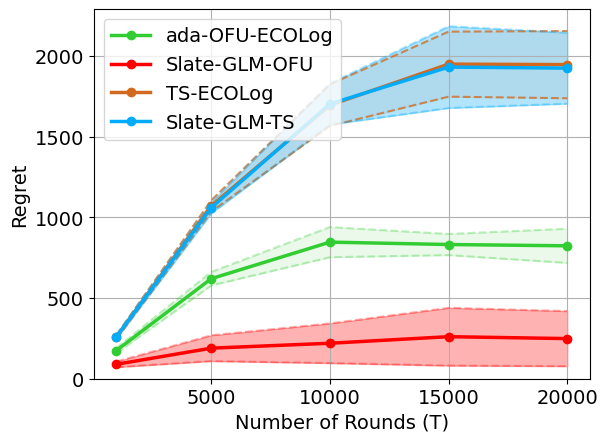

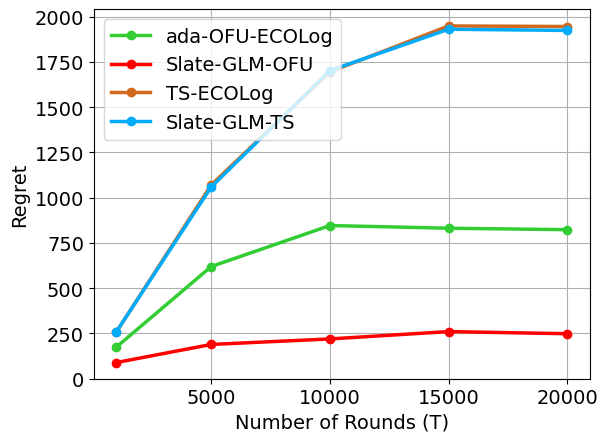

In [ ]:
horizons = [1000 , 5000 , 10000 , 15000, 20000]

ada_means , ada_std = aggregate("Results/ada_ofu_ecolog" , "regret", ["contexts=5" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)
slate_ofu_means , slate_ofu_std = aggregate("Results/slate_glm_ofu" , "regret", ["contexts=5" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)
slate_ts_means , slate_ts_std = aggregate("Results/slate_glm_TS" , "regret", ["contexts=5" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)
ts_means , ts_std = aggregate("Results/TS_ecolog" , "regret", ["contexts=5" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)


plt.plot(horizons , ada_means , "o-" ,  label = "ada-OFU-ECOLog" , color = "limegreen",  linewidth = 2.5)
plt.fill_between(horizons , np.array(ada_means) - 2 * np.array(ada_std) , np.array(ada_means) + 2 * np.array(ada_std) , color = "limegreen",  alpha = 0.1)
plt.plot(horizons , np.array(ada_means) - 2 * np.array(ada_std), '--' , color = "limegreen",  alpha = 0.3)
plt.plot(horizons , np.array(ada_means) + 2 * np.array(ada_std), '--' , color = "limegreen",  alpha = 0.3)

plt.plot(horizons , slate_ofu_means , "o-" ,  label = "Slate-GLM-OFU", color = "red", linewidth = 2.5)
plt.fill_between(horizons , np.array(slate_ofu_means) - 2 * np.array(slate_ofu_std) , np.array(slate_ofu_means) + 2 * np.array(slate_ofu_std) , color = "red",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ofu_means) - 2 * np.array(slate_ofu_std), '--' , color = "red",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ofu_means) + 2 * np.array(slate_ofu_std), '--' , color = "red",  alpha = 0.3)

plt.plot(horizons , ts_means , "o-" ,  label = "TS-ECOLog", color = "chocolate", linewidth = 2.5)
plt.fill_between(horizons , np.array(ts_means) - 2 * np.array(ts_std) , np.array(ts_means) + 2 * np.array(ts_std) , color = "chocolate", alpha = 0.1)
plt.plot(horizons , np.array(ts_means) - 2 * np.array(ts_std), '--' , color = "chocolate", alpha = 0.75)
plt.plot(horizons , np.array(ts_means) + 2 * np.array(ts_std), '--' , color = "chocolate", alpha = 0.75)

plt.plot(horizons , slate_ts_means , "o-" ,  label = "Slate-GLM-TS", color = "#02acfa", linewidth = 2.5)
plt.fill_between(horizons , np.array(slate_ts_means) - 2 * np.array(slate_ts_std) , np.array(slate_ts_means) + 2 * np.array(slate_ts_std) , color = "#02acfa",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ts_means) - 2 * np.array(slate_ts_std), '--' , color = "#02acfa",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ts_means) + 2 * np.array(slate_ts_std), '--' , color = "#02acfa",  alpha = 0.3)



plt.legend(loc = "upper left")
plt.grid()
plt.xlabel("Number of Rounds (T)")
plt.ylabel("Regret")
plt.ylim(0,)
plt.savefig("Results/Plots/Finite_Contexts_Error.pdf")
plt.show()

plt.plot(horizons , ada_means , "o-" , color = "limegreen" , label = "ada-OFU-ECOLog" , linewidth = 2.5)
plt.plot(horizons , slate_ofu_means , "o-" , color = "red",  label = "Slate-GLM-OFU", linewidth = 2.5)
plt.plot(horizons , ts_means , "o-" , color = "chocolate" , label = "TS-ECOLog", linewidth = 2.5)
plt.plot(horizons , slate_ts_means , "o-" , color = "#02acfa",  label = "Slate-GLM-TS", linewidth = 2.5)


plt.legend(loc = "upper left")
plt.grid()
plt.xlabel("Number of Rounds (T)")
plt.ylabel("Regret")
plt.ylim(0,)
plt.savefig("Results/Plots/Finite_Contexts.pdf")
plt.show()

#### b) Infinite Contexts

In [ ]:
horizons = [1000 , 5000 , 10000 , 15000, 20000]

alg_names = ["ada_ofu_ecolog" , "slate_glm_ofu" , "slate_glm_TS" , "TS_ecolog"]

for h in horizons:
    for run in range(0  ,20):
        reward_seed = ((123 * run)%1e7) + run
        for alg_name in alg_names:
            os.system(f"python3 main.py --alg_name {alg_name} --horizon {h} --arm_dim 5 --slot_count 3 --item_count 5 --reward_seed {int(reward_seed)}")

Original Length: 526
Length: 140
Length: 100
Original Length: 696
Length: 140
Length: 100
Original Length: 696
Length: 140
Length: 100
Original Length: 526
Length: 140
Length: 100


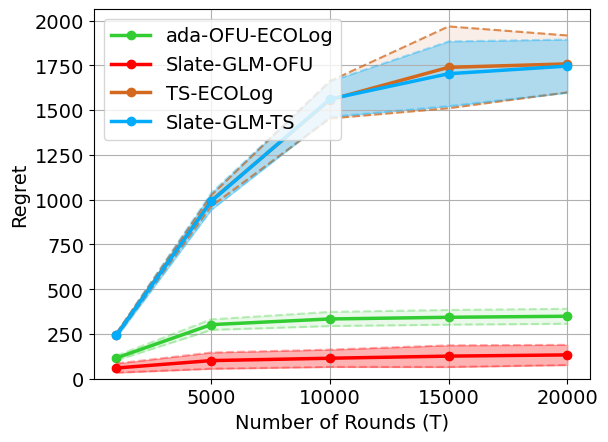

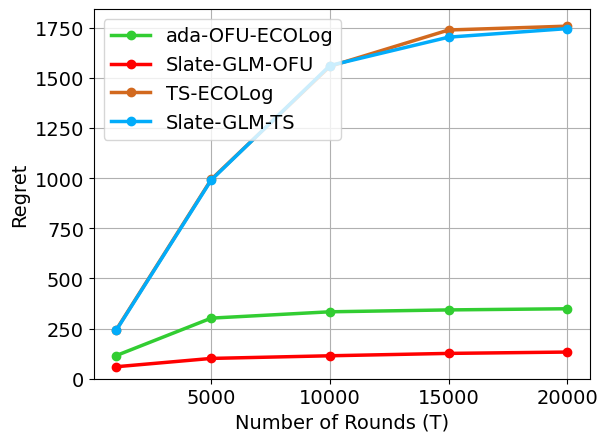

In [ ]:
horizons = [1000 , 5000 , 10000 , 15000, 20000]

ada_means , ada_std = aggregate("Results/ada_ofu_ecolog" , "regret", ["contexts=None" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)
slate_ofu_means , slate_ofu_std = aggregate("Results/slate_glm_ofu" , "regret", ["contexts=None" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)
slate_ts_means , slate_ts_std = aggregate("Results/slate_glm_TS" , "regret", ["contexts=None" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)
ts_means , ts_std = aggregate("Results/TS_ecolog" , "regret", ["contexts=None" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)


plt.plot(horizons , ada_means , "o-" ,  label = "ada-OFU-ECOLog" , color = "limegreen",  linewidth = 2.5)
plt.fill_between(horizons , np.array(ada_means) - 2 * np.array(ada_std) , np.array(ada_means) + 2 * np.array(ada_std) , color = "limegreen",  alpha = 0.1)
plt.plot(horizons , np.array(ada_means) - 2 * np.array(ada_std), '--' , color = "limegreen",  alpha = 0.3)
plt.plot(horizons , np.array(ada_means) + 2 * np.array(ada_std), '--' , color = "limegreen",  alpha = 0.3)

plt.plot(horizons , slate_ofu_means , "o-" ,  label = "Slate-GLM-OFU", color = "red", linewidth = 2.5)
plt.fill_between(horizons , np.array(slate_ofu_means) - 2 * np.array(slate_ofu_std) , np.array(slate_ofu_means) + 2 * np.array(slate_ofu_std) , color = "red",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ofu_means) - 2 * np.array(slate_ofu_std), '--' , color = "red",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ofu_means) + 2 * np.array(slate_ofu_std), '--' , color = "red",  alpha = 0.3)

plt.plot(horizons , ts_means , "o-" ,  label = "TS-ECOLog", color = "chocolate", linewidth = 2.5)
plt.fill_between(horizons , np.array(ts_means) - 2 * np.array(ts_std) , np.array(ts_means) + 2 * np.array(ts_std) , color = "chocolate", alpha = 0.1)
plt.plot(horizons , np.array(ts_means) - 2 * np.array(ts_std), '--' , color = "chocolate", alpha = 0.75)
plt.plot(horizons , np.array(ts_means) + 2 * np.array(ts_std), '--' , color = "chocolate", alpha = 0.75)

plt.plot(horizons , slate_ts_means , "o-" ,  label = "Slate-GLM-TS", color = "#02acfa", linewidth = 2.5)
plt.fill_between(horizons , np.array(slate_ts_means) - 2 * np.array(slate_ts_std) , np.array(slate_ts_means) + 2 * np.array(slate_ts_std) , color = "#02acfa",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ts_means) - 2 * np.array(slate_ts_std), '--' , color = "#02acfa",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ts_means) + 2 * np.array(slate_ts_std), '--' , color = "#02acfa",  alpha = 0.3)

plt.legend(loc = "upper left")
plt.grid()
plt.xlabel("Number of Rounds (T)")
plt.ylabel("Regret")
plt.ylim(0,)
plt.savefig("Results/Plots/Infinite_Contexts_Error.pdf")
plt.show()

plt.plot(horizons , ada_means , "o-" , color = "limegreen" , label = "ada-OFU-ECOLog" , linewidth = 2.5)
plt.plot(horizons , slate_ofu_means , "o-" , color = "red",  label = "Slate-GLM-OFU", linewidth = 2.5)
plt.plot(horizons , ts_means , "o-" , color = "chocolate" , label = "TS-ECOLog", linewidth = 2.5)
plt.plot(horizons , slate_ts_means , "o-" , color = "#02acfa",  label = "Slate-GLM-TS", linewidth = 2.5)


plt.legend(loc = "upper left")
plt.grid()
plt.xlabel("Number of Rounds (T)")
plt.ylabel("Regret")
plt.ylim(0,)
plt.savefig("Results/Plots/Infinite_Contexts.pdf")
plt.show()

### Experiment 2: Per-Round Time vs. $N$

In [ ]:
alg_names = ["ada_ofu_ecolog" , "slate_glm_ofu" , "slate_glm_TS" , "TS_ecolog"]

for slot in [3,4,5,6]:
    for run in range(0,10):
        reward_seed = ((123 * run)%1e7) + run
        for alg_name in alg_names:
            os.system(f"python3 main.py --alg_name {alg_name} --horizon 1000 --arm_dim 5 --slot_count {slot} --item_count 7 --reward_seed {int(reward_seed)}")

Original Length: 526
Length: 40
Original Length: 696
Length: 40
Original Length: 526
Length: 40
Original Length: 696
Length: 40


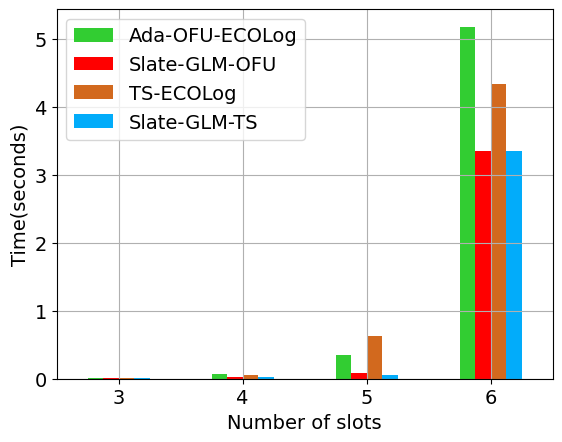

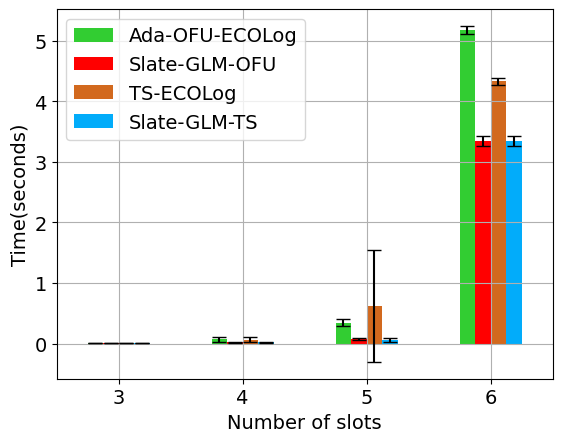

   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0          0.0089         0.0046     0.0076        0.0049
1          0.0707         0.0226     0.0612        0.0192
2          0.3459         0.0792     0.6251        0.0613
3          5.1804         3.3462     4.3302        3.3483
   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0          0.0021         0.0016     0.0009        0.0016
1          0.0432         0.0054     0.0416        0.0048
2          0.0572         0.0146     0.9270        0.0344
3          0.0648         0.0793     0.0567        0.0853


In [ ]:
slots = [3,4,5,6]

ada_pull_mean , ada_pull_std = aggregate("Results/ada_ofu_ecolog" , "per_round_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
slate_glm_ofu_pull_mean , slate_glm_ofu_pull_std = aggregate("Results/slate_glm_ofu" , "per_round_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
ts_pull_mean , ts_pull_std = aggregate("Results/TS_ecolog" , "per_round_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
slate_glm_ts_pull_mean , slate_glm_ts_pull_std = aggregate("Results/slate_glm_TS" , "per_round_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)

mean_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_mean , "Slate-GLM-OFU" : np.array(slate_glm_ofu_pull_mean) , "TS-ECOLog" : ts_pull_mean , "Slate-GLM-TS" : np.array(slate_glm_ts_pull_mean)}
std_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_std , "Slate-GLM-OFU" : slate_glm_ofu_pull_std , "TS-ECOLog" : ts_pull_std , "Slate-GLM-TS" : slate_glm_ts_pull_std}



mean_df = pd.DataFrame(mean_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" , ylabel = "Time(seconds)", rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/per_round_time_average.pdf")
# plt.yscale("log")
plt.show()

mean_df = pd.DataFrame(mean_pull_dict)
std_df = pd.DataFrame(std_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots", ylabel = "Time(seconds)" , yerr = 2*std_df , capsize = 5,  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/per_round_time_average_error.pdf")
plt.show()

print(mean_df.round(4))
print((std_df*2).round(4))

Original Length: 526
Length: 40
Original Length: 696
Length: 40
Original Length: 526
Length: 40
Original Length: 696
Length: 40


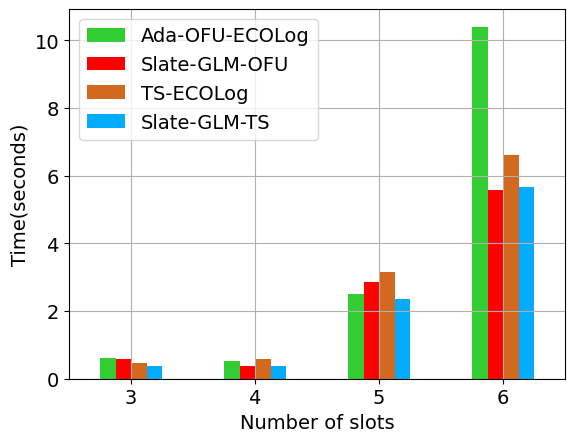

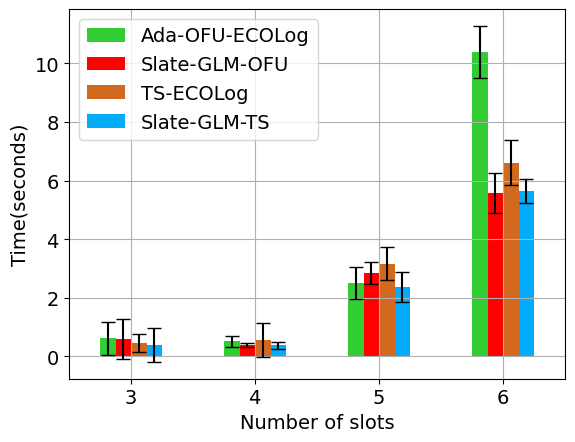

   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0          0.6118         0.5812     0.4602        0.3813
1          0.5192         0.3895     0.5721        0.3770
2          2.5067         2.8454     3.1617        2.3676
3         10.4013         5.5747     6.6190        5.6578
   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0          0.5611         0.6829     0.3071        0.5710
1          0.1829         0.0739     0.5777        0.1135
2          0.5543         0.3650     0.5660        0.5219
3          0.8808         0.6876     0.7785        0.4111


In [ ]:
slots = [3,4,5,6]

ada_pull_mean , ada_pull_std = aggregate("Results/ada_ofu_ecolog" , "per_round_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
slate_glm_ofu_pull_mean , slate_glm_ofu_pull_std = aggregate("Results/slate_glm_ofu" , "per_round_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
ts_pull_mean , ts_pull_std = aggregate("Results/TS_ecolog" , "per_round_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
slate_glm_ts_pull_mean , slate_glm_ts_pull_std = aggregate("Results/slate_glm_TS" , "per_round_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
mean_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_mean , "Slate-GLM-OFU" : slate_glm_ofu_pull_mean , "TS-ECOLog" : ts_pull_mean , "Slate-GLM-TS" : slate_glm_ts_pull_mean}
std_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_std , "Slate-GLM-OFU" : slate_glm_ofu_pull_std , "TS-ECOLog" : ts_pull_std , "Slate-GLM-TS" : slate_glm_ts_pull_std}

mean_df = pd.DataFrame(mean_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" , ylabel = "Time(seconds)",  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/per_round_time_max.pdf")
plt.show()

mean_df = pd.DataFrame(mean_pull_dict)
std_df = pd.DataFrame(std_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" ,ylabel = "Time(seconds)",  yerr = 2*std_df , capsize = 5,  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/per_round_time_max_error.pdf")
plt.show()

print(mean_df.round(4))
print((std_df*2).round(4))

Original Length: 526
Length: 40
Original Length: 696
Length: 40
Original Length: 526
Length: 40
Original Length: 696
Length: 40


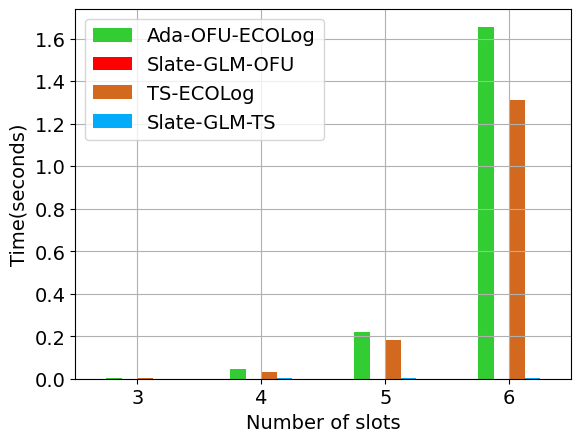

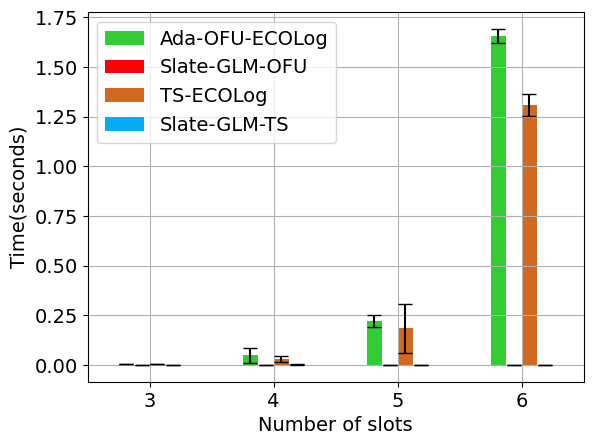

   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0             4.3            0.3        3.1           0.6
1            47.5            0.8       30.3           2.2
2           221.4            0.6      184.1           1.2
3          1655.6            0.9     1309.4           1.9
   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0             0.2            0.0        0.1           0.1
1            36.4            0.9       15.6           1.1
2            30.1            0.2      121.8           0.5
3            36.3            0.2       55.3           0.2


In [ ]:
slots = [3,4,5,6]

ada_pull_mean , ada_pull_std = aggregate("Results/ada_ofu_ecolog" , "pull_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
slate_glm_ofu_pull_mean , slate_glm_ofu_pull_std = aggregate("Results/slate_glm_ofu" , "pull_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
ts_pull_mean , ts_pull_std = aggregate("Results/TS_ecolog" , "pull_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
slate_glm_ts_pull_mean , slate_glm_ts_pull_std = aggregate("Results/slate_glm_TS" , "pull_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
mean_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_mean , "Slate-GLM-OFU" : slate_glm_ofu_pull_mean , "TS-ECOLog" : ts_pull_mean , "Slate-GLM-TS" : slate_glm_ts_pull_mean}
std_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_std , "Slate-GLM-OFU" : slate_glm_ofu_pull_std , "TS-ECOLog" : ts_pull_std , "Slate-GLM-TS" : slate_glm_ts_pull_std}

mean_df = pd.DataFrame(mean_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" , ylabel = "Time(seconds)",  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/pull_time_average.pdf")
plt.show()

mean_df = pd.DataFrame(mean_pull_dict)
std_df = pd.DataFrame(std_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" ,ylabel = "Time(seconds)",  yerr = 2*std_df , capsize = 5,  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/pull_time_average_error.pdf")
plt.show()

print(mean_df.round(4)*1000)
print((std_df*2).round(4)*1000)

Original Length: 526
Length: 40
Original Length: 696
Length: 40
Original Length: 526
Length: 40
Original Length: 696
Length: 40


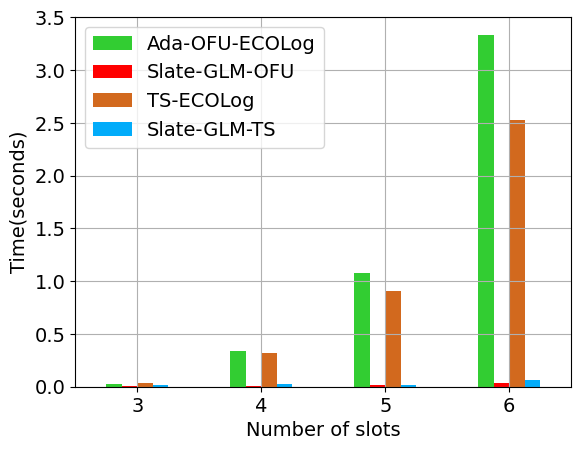

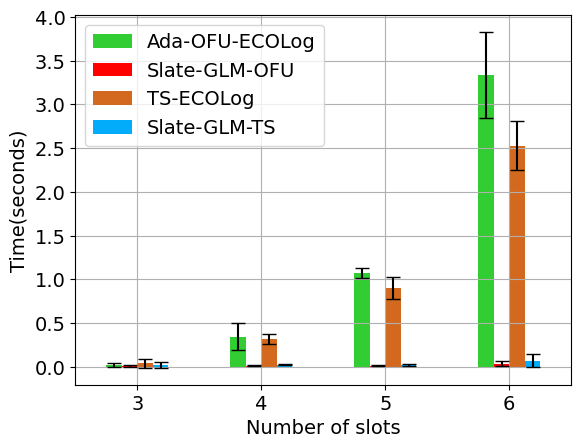

   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0            23.0            9.5       36.6          19.2
1           341.8           10.5      316.7          22.8
2          1075.7           12.0      905.3          13.8
3          3335.5           35.8     2528.3          68.3
   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0            24.5           12.5       47.7          33.4
1           154.8            7.3       57.1           5.4
2            57.8            9.7      126.5          11.5
3           494.6           28.9      278.2          71.1


In [ ]:
slots = [3,4,5,6]

ada_pull_mean , ada_pull_std = aggregate("Results/ada_ofu_ecolog" , "pull_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
slate_glm_ofu_pull_mean , slate_glm_ofu_pull_std = aggregate("Results/slate_glm_ofu" , "pull_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
ts_pull_mean , ts_pull_std = aggregate("Results/TS_ecolog" , "pull_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
slate_glm_ts_pull_mean , slate_glm_ts_pull_std = aggregate("Results/slate_glm_TS" , "pull_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
mean_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_mean , "Slate-GLM-OFU" : slate_glm_ofu_pull_mean , "TS-ECOLog" : ts_pull_mean , "Slate-GLM-TS" : slate_glm_ts_pull_mean}
std_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_std , "Slate-GLM-OFU" : slate_glm_ofu_pull_std , "TS-ECOLog" : ts_pull_std , "Slate-GLM-TS" : slate_glm_ts_pull_std}

mean_df = pd.DataFrame(mean_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" , ylabel = "Time(seconds)",  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/pull_time_max.pdf")
plt.show()

mean_df = pd.DataFrame(mean_pull_dict)
std_df = pd.DataFrame(std_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" ,ylabel = "Time(seconds)",  yerr = 2*std_df , capsize = 5,  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/pull_time_max_error.pdf")
plt.show()

print(mean_df.round(4)*1000)
print((std_df*2).round(4)*1000)

Original Length: 526
Length: 40
Original Length: 696
Length: 40
Original Length: 526
Length: 40
Original Length: 696
Length: 40


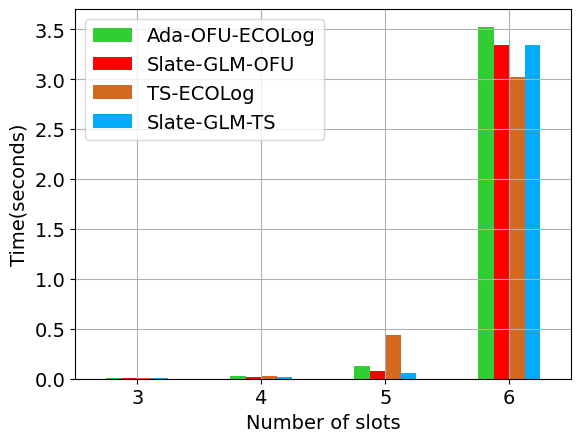

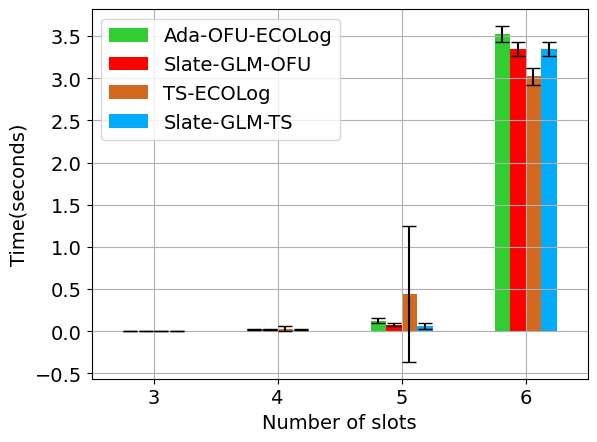

   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0          0.0046         0.0043     0.0045        0.0044
1          0.0231         0.0218     0.0309        0.0171
2          0.1245         0.0786     0.4411        0.0601
3          3.5247         3.3454     3.0208        3.3464
   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0          0.0022         0.0016     0.0009        0.0016
1          0.0081         0.0062     0.0275        0.0042
2          0.0315         0.0145     0.8053        0.0340
3          0.0952         0.0794     0.1025        0.0854


In [ ]:
slots = [3,4,5,6]

ada_pull_mean , ada_pull_std = aggregate("Results/ada_ofu_ecolog" , "update_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
slate_glm_ofu_pull_mean , slate_glm_ofu_pull_std = aggregate("Results/slate_glm_ofu" , "update_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
ts_pull_mean , ts_pull_std = aggregate("Results/TS_ecolog" , "update_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
slate_glm_ts_pull_mean , slate_glm_ts_pull_std = aggregate("Results/slate_glm_TS" , "update_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.mean)
mean_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_mean , "Slate-GLM-OFU" : slate_glm_ofu_pull_mean , "TS-ECOLog" : ts_pull_mean , "Slate-GLM-TS" : slate_glm_ts_pull_mean}
std_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_std , "Slate-GLM-OFU" : slate_glm_ofu_pull_std , "TS-ECOLog" : ts_pull_std , "Slate-GLM-TS" : slate_glm_ts_pull_std}

mean_df = pd.DataFrame(mean_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" , ylabel = "Time(seconds)",  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/update_time_average.pdf")
plt.show()

mean_df = pd.DataFrame(mean_pull_dict)
std_df = pd.DataFrame(std_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" ,ylabel = "Time(seconds)",  yerr = 2*std_df , capsize = 5,  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/update_time_average_error.pdf")
plt.show()

print(mean_df.round(4))
print((std_df*2).round(4))

Original Length: 526
Length: 40
Original Length: 696
Length: 40
Original Length: 526
Length: 40
Original Length: 696
Length: 40


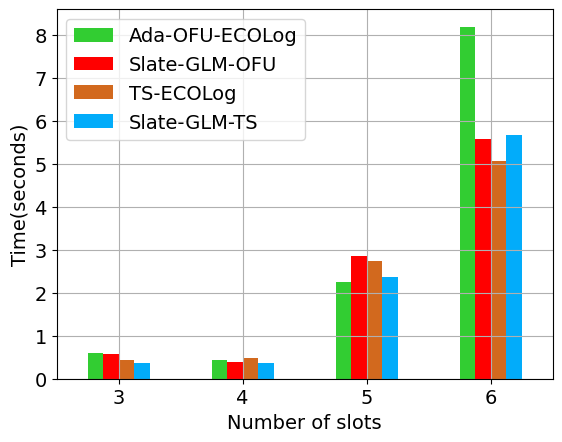

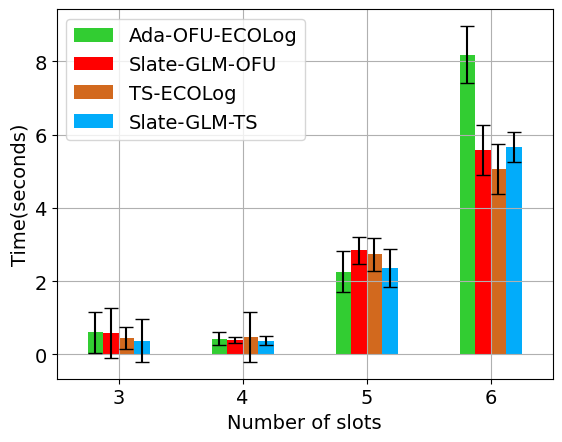

   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0          0.6066         0.5809     0.4449        0.3771
1          0.4316         0.3885     0.4749        0.3746
2          2.2535         2.8444     2.7368        2.3665
3          8.1858         5.5741     5.0614        5.6566
   Ada-OFU-ECOLog  Slate-GLM-OFU  TS-ECOLog  Slate-GLM-TS
0          0.5587         0.6831     0.3043        0.5796
1          0.1881         0.0742     0.6798        0.1164
2          0.5609         0.3666     0.4484        0.5218
3          0.7803         0.6876     0.6749        0.4110


In [ ]:
slots = [3,4,5,6]

ada_pull_mean , ada_pull_std = aggregate("Results/ada_ofu_ecolog" , "update_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
slate_glm_ofu_pull_mean , slate_glm_ofu_pull_std = aggregate("Results/slate_glm_ofu" , "update_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
ts_pull_mean , ts_pull_std = aggregate("Results/TS_ecolog" , "update_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
slate_glm_ts_pull_mean , slate_glm_ts_pull_std = aggregate("Results/slate_glm_TS" , "update_time", [f"K=7_T=1000_"], [f"N={s}_" for s in slots],np.max)
mean_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_mean , "Slate-GLM-OFU" : slate_glm_ofu_pull_mean , "TS-ECOLog" : ts_pull_mean , "Slate-GLM-TS" : slate_glm_ts_pull_mean}
std_pull_dict = {"Ada-OFU-ECOLog" : ada_pull_std , "Slate-GLM-OFU" : slate_glm_ofu_pull_std , "TS-ECOLog" : ts_pull_std , "Slate-GLM-TS" : slate_glm_ts_pull_std}

mean_df = pd.DataFrame(mean_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" , ylabel = "Time(seconds)",  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/update_time_max.pdf")
plt.show()

mean_df = pd.DataFrame(mean_pull_dict)
std_df = pd.DataFrame(std_pull_dict)
mean_df.plot(kind = "bar", xlabel = "Number of slots" ,ylabel = "Time(seconds)",  yerr = 2*std_df , capsize = 5,  rot = 0 , color = ["limegreen", "red", "chocolate", "#02acfa"])
plt.xticks([0,1,2,3] , [3,4,5,6])
plt.grid()
plt.savefig("Results/Plots/update_time_max_error.pdf")
plt.show()

print(mean_df.round(4))
print((std_df*2).round(4))

### Experiment 3: $R(T)$ vs. $T$ for the non-contextual setting

In [ ]:
horizons = [1000 , 5000, 10000, 20000, 30000, 40000,50000]
alg_names = [ "ordered_bandit_linear_loss", "slate_glm_ofu" , "ada_ofu_ecolog" , "slate_glm_TS" , "TS_ecolog" , "mps" , "slate_glm_TS_Fixed"]
for h in horizons:
    for run in range(0,20):
        reward_seed = ((123 * run)%1e7) + run
        for alg_name in alg_names:
            os.system(f"python3 main.py --alg_name {alg_name} --num_contexts 1 --horizon {h} --arm_dim 5 --slot_count 3 --item_count 5 --reward_seed {int(reward_seed)} --arm_seed 456")

Aggregating results for ada-OFU-ECOLog
Original Length: 526
Length: 285
Length: 285
Aggregating results for slate-GLM-OFU
Original Length: 526
Length: 285
Length: 285
Aggregating results for slate-GLM-TS
Original Length: 526
Length: 285
Length: 285
Aggregating results for TS-ECOLog
Original Length: 526
Length: 285
Length: 285
Aggregating results for MPS
Original Length: 386
Length: 385
Length: 265
Aggregating results for Ordered-Slate-Bandit
Original Length: 266
Length: 265
Length: 265
Aggregating results for Slate-GLM-TS-Fixed
Original Length: 266
Length: 265
Length: 265


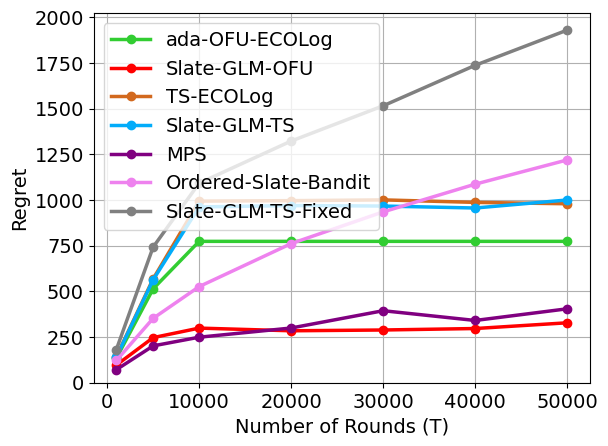

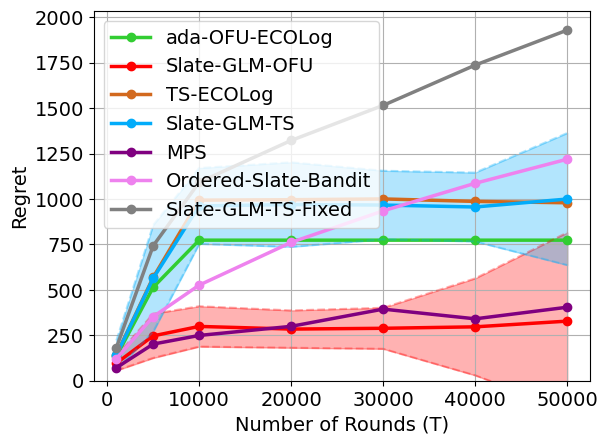

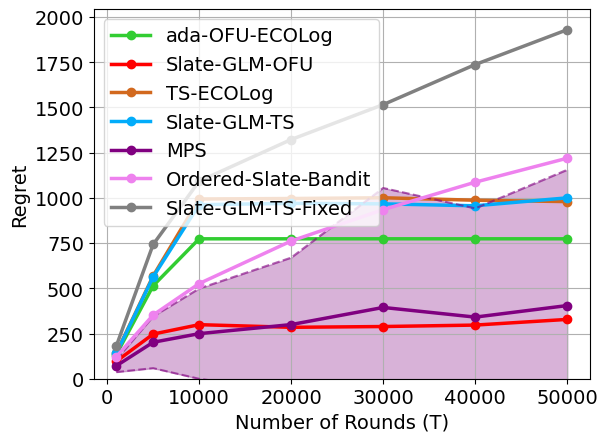

In [ ]:
horizons = [1000 , 5000, 10000, 20000, 30000, 40000,50000]

print("Aggregating results for ada-OFU-ECOLog")
ada_means , ada_std = aggregate("Results/ada_ofu_ecolog" , "regret", ["contexts=1" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)

print("Aggregating results for slate-GLM-OFU")
slate_ofu_means , slate_ofu_std = aggregate("Results/slate_glm_ofu" , "regret", ["contexts=1" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)

print("Aggregating results for slate-GLM-TS")
slate_ts_means , slate_ts_std = aggregate("Results/slate_glm_TS" , "regret", ["contexts=1" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)

print("Aggregating results for TS-ECOLog")
ts_means , ts_std = aggregate("Results/TS_ecolog" , "regret", ["contexts=1" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)

print("Aggregating results for MPS")
mps_means , mps_std = aggregate("Results/mps" , "regret", ["contexts=1" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)

print("Aggregating results for Ordered-Slate-Bandit")
ordered_means , ordered_std = aggregate("Results/ordered_bandit_linear_loss" , "regret", ["contexts=1" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)

print("Aggregating results for Slate-GLM-TS-Fixed")
warmup_means , warmup_std = aggregate("Results/slate_glm_TS_Fixed" , "regret", ["contexts=1" , "N=3_K=5_T="] , [f"T={h}_" for h in horizons],  np.sum)

plt.plot(horizons , ada_means , "o-" ,  label = "ada-OFU-ECOLog" , color = "limegreen",  linewidth = 2.5)
plt.plot(horizons , slate_ofu_means , "o-" ,  label = "Slate-GLM-OFU", color = "red", linewidth = 2.5)
plt.plot(horizons , ts_means , "o-" ,  label = "TS-ECOLog", color = "chocolate", linewidth = 2.5)
plt.plot(horizons , slate_ts_means , "o-" ,  label = "Slate-GLM-TS", color = "#02acfa", linewidth = 2.5)
plt.plot(horizons , mps_means , "o-" ,  label = "MPS", color = "purple", linewidth = 2.5)
plt.plot(horizons , ordered_means , "o-" ,  label = "Ordered-Slate-Bandit",color = "violet", linewidth = 2.5)
plt.plot(horizons , warmup_means , "o-" ,  label = "Slate-GLM-TS-Fixed", color = "gray", linewidth = 2.5)

plt.legend(loc = "upper left")
plt.grid()
plt.xlabel("Number of Rounds (T)")
plt.ylabel("Regret")
plt.ylim(0,)
plt.savefig("Results/Plots/non_contextual.pdf")
plt.show()

plt.plot(horizons , ada_means , "o-" ,  label = "ada-OFU-ECOLog" , color = "limegreen",  linewidth = 2.5)

plt.plot(horizons , slate_ofu_means , "o-" ,  label = "Slate-GLM-OFU", color = "red", linewidth = 2.5)
plt.fill_between(horizons , np.array(slate_ofu_means) - 2 * np.array(slate_ofu_std) , np.array(slate_ofu_means) + 2 * np.array(slate_ofu_std) , color = "red",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ofu_means) - 2 * np.array(slate_ofu_std), '--' , color = "red",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ofu_means) + 2 * np.array(slate_ofu_std), '--' , color = "red",  alpha = 0.3)

plt.plot(horizons , ts_means , "o-" ,  label = "TS-ECOLog", color = "chocolate", linewidth = 2.5)

plt.plot(horizons , slate_ts_means , "o-" ,  label = "Slate-GLM-TS", color = "#02acfa", linewidth = 2.5)
plt.fill_between(horizons , np.array(slate_ts_means) - 2 * np.array(slate_ts_std) , np.array(slate_ts_means) + 2 * np.array(slate_ts_std) , color = "#02acfa",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ts_means) - 2 * np.array(slate_ts_std), '--' , color = "#02acfa",  alpha = 0.3)
plt.plot(horizons , np.array(slate_ts_means) + 2 * np.array(slate_ts_std), '--' , color = "#02acfa",  alpha = 0.3)

plt.plot(horizons , mps_means , "o-" ,  label = "MPS", color = "purple", linewidth = 2.5)
plt.plot(horizons , ordered_means , "o-" ,  label = "Ordered-Slate-Bandit",color = "violet", linewidth = 2.5)
plt.plot(horizons , warmup_means , "o-" ,  label = "Slate-GLM-TS-Fixed", color = "gray", linewidth = 2.5)

plt.legend(loc = "upper left")
plt.grid()
plt.xlabel("Number of Rounds (T)")
plt.ylabel("Regret")
plt.ylim(0,)
plt.savefig("Results/Plots/non_contextual_our_error.pdf")
plt.show()

plt.plot(horizons , ada_means , "o-" ,  label = "ada-OFU-ECOLog" , color = "limegreen",  linewidth = 2.5)

plt.plot(horizons , slate_ofu_means , "o-" ,  label = "Slate-GLM-OFU", color = "red", linewidth = 2.5)

plt.plot(horizons , ts_means , "o-" ,  label = "TS-ECOLog", color = "chocolate", linewidth = 2.5)

plt.plot(horizons , slate_ts_means , "o-" ,  label = "Slate-GLM-TS", color = "#02acfa", linewidth = 2.5)

plt.plot(horizons , mps_means , "o-" ,  label = "MPS", color = "purple", linewidth = 2.5)
plt.fill_between(horizons , np.array(mps_means) - 2 * np.array(mps_std) , np.array(mps_means) + 2 * np.array(mps_std) , color = "purple",  alpha = 0.3)
plt.plot(horizons , np.array(mps_means) - 2 * np.array(mps_std), '--' , color = "purple",  alpha = 0.6)
plt.plot(horizons , np.array(mps_means) + 2 * np.array(mps_std), '--' , color = "purple",  alpha = 0.6)

plt.plot(horizons , ordered_means , "o-" ,  label = "Ordered-Slate-Bandit",color = "violet", linewidth = 2.5)
plt.plot(horizons , warmup_means , "o-" ,  label = "Slate-GLM-TS-Fixed", color = "gray", linewidth = 2.5)

plt.legend(loc = "upper left")
plt.grid()
plt.xlabel("Number of Rounds (T)")
plt.ylabel("Regret")
plt.ylim(0,)
plt.savefig("Results/Plots/non_contextual_mps_error.pdf")
plt.show()

### Eigenvalue Experiment: Validation of Diversity Assumption

In [ ]:
alg_names = ["slate_glm_ofu" , "slate_glm_TS"]
for alg_name in alg_names:
        os.system(f"python3 eigenvalue_experiment.py --alg_name {alg_name}  --horizon 10000 --arm_dim 5 --slot_count 3 --item_count 5 --seed 258 --num_runs 100")

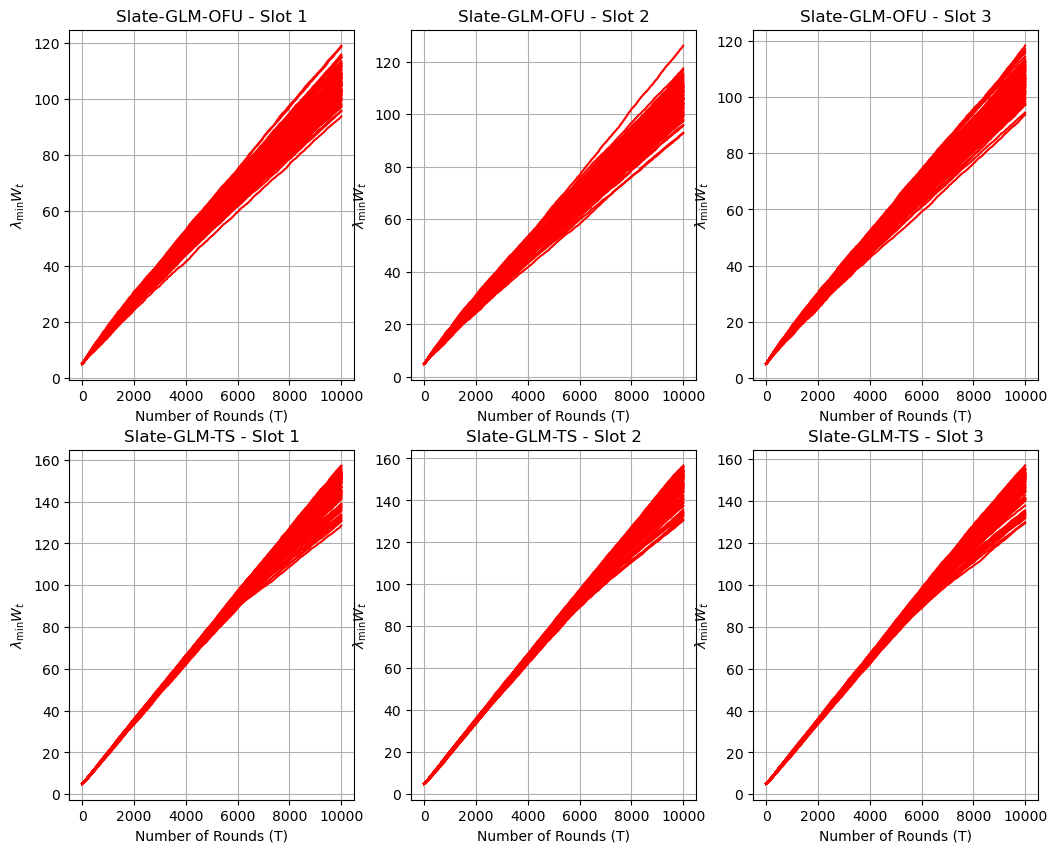

In [9]:
plt.rcParams.update({'font.size': 10})


folder = "Results/Eigenvalue_Experiment_Results"
ofu_eig = [[] , [] , []]
for file in os.listdir(f"{folder}/slate_glm_ofu"):
    all_eig = np.load(f"{folder}/slate_glm_ofu/{file}")
    ofu_eig[0].append(all_eig[0])
    ofu_eig[1].append(all_eig[1])
    ofu_eig[2].append(all_eig[2])


ts_eig = [[] , [] , []]
for file in os.listdir(f"{folder}/slate_glm_ts"):
    all_eig = np.load(f"{folder}/slate_glm_ts/{file}")
    ts_eig[0].append(all_eig[0])
    ts_eig[1].append(all_eig[1])
    ts_eig[2].append(all_eig[2])

horizon = [_ for _ in range(10000)]

plt.figure(figsize = (12.5,10))
plt.subplot(2,3,1)
for i in range(100):
    plt.plot(horizon , ofu_eig[0][i] , '-' , color = "red")
plt.xlabel("Number of Rounds (T)")
plt.ylabel("$\\lambda_{\\text{min}} W_t$")
plt.grid()
plt.gca().set_title('Slate-GLM-OFU - Slot 1')

plt.subplot(2,3,2)
for i in range(100):
    plt.plot(horizon , ofu_eig[1][i] , '-' , color = "red")
plt.xlabel("Number of Rounds (T)")
plt.ylabel("$\\lambda_{\\text{min}} W_t$")
plt.grid()
plt.gca().set_title('Slate-GLM-OFU - Slot 2')

plt.subplot(2,3,3)
for i in range(100):
    plt.plot(horizon , ofu_eig[2][i] , '-' , color = "red")
plt.xlabel("Number of Rounds (T)")
plt.ylabel("$\\lambda_{\\text{min}} W_t$")
plt.grid()
plt.gca().set_title('Slate-GLM-OFU - Slot 3')

plt.subplot(2,3,4)
for i in range(100):
    plt.plot(horizon , ts_eig[0][i] , '-' , color = "red")
plt.xlabel("Number of Rounds (T)")
plt.ylabel("$\\lambda_{\\text{min}} W_t$")
plt.grid()
plt.gca().set_title('Slate-GLM-TS - Slot 1')

plt.subplot(2,3,5)
for i in range(100):
    plt.plot(horizon , ts_eig[1][i] , '-' , color = "red")
plt.xlabel("Number of Rounds (T)")
plt.ylabel("$\\lambda_{\\text{min}} W_t$")
plt.grid()
plt.gca().set_title('Slate-GLM-TS - Slot 2')

plt.subplot(2,3,6)
for i in range(100):
    plt.plot(horizon , ts_eig[2][i] , '-' , color = "red")
plt.xlabel("Number of Rounds (T)")
plt.ylabel("$\\lambda_{\\text{min}} W_t$")
plt.grid()
plt.gca().set_title('Slate-GLM-TS - Slot 3')

plt.show()